In [1]:
%reload_ext autoreload
%autoreload 1
# %aimport imageDataset

In [1]:
import os

os.environ['KAGGLE_USERNAME']='default404'
os.environ['KAGGLE_KEY']='9a268598f579df0f73fe8bfaf412da59'

In [2]:
!pip install kaggle 
!kaggle datasets download -d ma7555/cat-breeds-dataset
!unzip -q cat*

100% 1.92G/1.93G [00:17<00:00, 115MB/s]
100% 1.93G/1.93G [00:17<00:00, 116MB/s]


In [32]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import preprocessing, model_selection
import cv2
from torch import utils
import albumentations as A
from tqdm import tqdm
from skimage import io

In [4]:
from pathlib import Path
from os import path

img_root_dir = Path('images')
image_paths = list(img_root_dir.glob(r'**/*.jpg'))
labels_str = list(map(lambda path: os.path.split(os.path.split(path)[0])[1], image_paths))

In [5]:
label_encoder = preprocessing.LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels_str)

In [6]:
df_full = pd.DataFrame([image_paths, labels_encoded]).T
df_full.columns =['path', 'label']

In [7]:
df_full.drop(df_full.query('label == 66').index, axis = 0, inplace = True)

In [9]:
train_data, val_data = model_selection.train_test_split(df_full, train_size = 0.95, stratify = df_full['label'])

In [10]:
train_data.reset_index(drop = True, inplace = True)
val_data.reset_index(drop = True, inplace = True)

In [11]:
image_transforms = {
    'train': A.Compose([
        A.Resize(224, 224),
        A.HorizontalFlip(p = 0.6),
        A.Rotate([-40, 40], border_mode = cv2.BORDER_CONSTANT)
    ]), 
    'val': A.Compose([
        A.Resize(224, 224)
    ])
}

In [31]:
from imageDataset import customDataset
dataset = {
    'train': customDataset(train_data, image_transforms['train']),
    'val': customDataset(val_data, image_transforms['val'])
    }

dataset_sizes = {x: len(dataset[x]) for x in ['train', 'val']}

In [21]:
class catsNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            # nn.Conv2d(3, 8, 3, padding = 'same'),
            # nn.ReLU(),
            # nn.MaxPool2d(2, 2),
            # nn.Conv2d(8, 16, 3, padding = 'same'),
            # nn.ReLU(),
            # nn.MaxPool2d(2, 2),
            # nn.Conv2d(16, 32, 3, padding = 'same'),
            # nn.ReLU(),
            # nn.MaxPool2d(2, 2),
            # nn.Conv2d(32, 64, 3, padding = 'same'),
            # nn.ReLU(),
            # nn.MaxPool2d(2, 2),
            # nn.Conv2d(64, 84, 3, padding = 'same'),
            # nn.ReLU(),
            # nn.MaxPool2d(2, 2),
            # nn.Flatten(),
            # nn.Linear(7*7*84, 1024),
            # nn.Linear(1024, 128),
            # nn.Linear(128, 66)
                        ## image size = 224x224
            nn.Conv2d(3, 16, kernel_size = 3, padding = 'same'),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size = 3, padding = 'same'),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32,32, kernel_size = 3, padding = 'same'),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32,32, kernel_size = 3, padding = 'same'),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32,32, kernel_size = 3, padding = 'same'),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(7*7*32, 112),
            nn.Linear(112, 66),
        )
    
    def forward(self, input):
        logits = self.layers(input)
        return logits


In [32]:
LEARNING_RATE = 1e-3
EPOCHS = 10
BATCH_SIZE = 256
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

dataloader = {
    x: utils.data.DataLoader(dataset[x], batch_size = BATCH_SIZE, num_workers = 1) for x in ['train', 'val']
}

def train_loop(dataloader, model, loss_func, optimizer, scheduler, epoch):
    model.train()
    running_loss, running_acc = 0,0
    loop = tqdm(enumerate(dataloader, start = 1), total = len(dataloader))
    for batch, (input, target) in loop:
        input, target = input.to(device), target.to(device)
        pred = model(input)
        loss = loss_func(pred, target)
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        running_loss += loss.item() * input.shape[0]
        running_acc += (pred.argmax(1) == target).sum().item()

        loop.set_description(f"[Train]Epoch [{epoch}/{EPOCHS}]")

    epoch_loss = running_loss/dataset_sizes['train']
    epoch_acc = float(running_acc)/dataset_sizes['train']

    scheduler.step(epoch_loss)
    print(f'\n running loss: {epoch_loss}, running acc: {epoch_acc}')

def validation_loop(dataloader, model, loss_func, optimizer, epoch):
    running_loss, running_acc = 0, 0
    model.eval()
    loop = tqdm(enumerate(dataloader, start = 1), total = len(dataloader))
    
    with torch.no_grad():
        for batch, (input, target) in loop:
            input, target= input.to(device), target.to(device)
            pred = model(input)
            loss = loss_func(pred, target)
            running_loss += loss.item() * input.shape[0]
            running_acc += (pred.argmax(1) == target).sum().item()

            loop.set_description(f"[VAL] Epoch [{epoch}/{EPOCHS}]")

    print(f"\n running loss: {running_loss/dataset_sizes['val']}, running acc: {float(running_acc)/dataset_sizes['val']}")


    
model = catsNN().to(device)

In [ ]:
loss_func = nn.crossentropyloss()
optimizer = optim.adam(model.parameters(), lr = LEARNING_RATE)
scheduler = optim.lr_scheduler.reducelronplateau(optimizer, patience = 5, factor = 0.1, verbose = True)

In [ ]:
for epoch in range(EPOCHS):
    train_loop(dataloader['train'], model, loss_func, optimizer, scheduler, epoch)
    validation_loop(dataloader['val'], model, loss_func, optimizer, epoch)

[Train]Epoch [0/10]: 100%|██████████| 470/470 [09:44<00:00,  1.24s/it]


 running loss: 2.6003968781241507, running acc: 0.41834130118478485



[VAL] Epoch [0/10]: 100%|██████████| 25/25 [00:25<00:00,  1.02s/it]


 running loss: 2.496376547235728, running acc: 0.4241036171220976



[Train]Epoch [1/10]: 100%|██████████| 470/470 [08:52<00:00,  1.13s/it]


 running loss: 2.4504164074989148, running acc: 0.42201621284556223



[VAL] Epoch [1/10]: 100%|██████████| 25/25 [00:24<00:00,  1.03it/s]


 running loss: 2.419283670980658, running acc: 0.42599905228241985



[Train]Epoch [2/10]: 100%|██████████| 470/470 [08:48<00:00,  1.12s/it]


 running loss: 2.389416631957494, running acc: 0.42362918312201203



[VAL] Epoch [2/10]: 100%|██████████| 25/25 [00:24<00:00,  1.00it/s]


 running loss: 2.3640164873683234, running acc: 0.4313694519033328



[Train]Epoch [3/10]: 100%|██████████| 470/470 [09:05<00:00,  1.16s/it]


 running loss: 2.3427102648624634, running acc: 0.42599043857825813



[VAL] Epoch [3/10]: 100%|██████████| 25/25 [00:25<00:00,  1.00s/it]


 running loss: 2.3209379651387936, running acc: 0.4346864634338967



[Train]Epoch [4/10]: 100%|██████████| 470/470 [08:45<00:00,  1.12s/it]


 running loss: 2.3044920979565036, running acc: 0.4290667220951985



[VAL] Epoch [4/10]: 100%|██████████| 25/25 [00:24<00:00,  1.01it/s]


 running loss: 2.2729151271527233, running acc: 0.4378455220344337



[Train]Epoch [5/10]: 100%|██████████| 470/470 [08:59<00:00,  1.15s/it]


 running loss: 2.2709120455226293, running acc: 0.432824776553731



[VAL] Epoch [5/10]: 100%|██████████| 25/25 [00:24<00:00,  1.00it/s]


 running loss: 2.2541535980722913, running acc: 0.4405307218448902



[Train]Epoch [6/10]: 100%|██████████| 470/470 [08:56<00:00,  1.14s/it]


 running loss: 2.239549565453015, running acc: 0.43565994595718144



[VAL] Epoch [6/10]: 100%|██████████| 25/25 [00:25<00:00,  1.01s/it]


 running loss: 2.226129394179365, running acc: 0.4416363923550782



[Train]Epoch [7/10]: 100%|██████████| 470/470 [09:13<00:00,  1.18s/it]


 running loss: 2.215634789830606, running acc: 0.4387445437538973



[VAL] Epoch [7/10]: 100%|██████████| 25/25 [00:25<00:00,  1.03s/it]


 running loss: 2.1948831364961996, running acc: 0.448270415416206



[Train]Epoch [8/10]: 100%|██████████| 470/470 [09:23<00:00,  1.20s/it]


 running loss: 2.1969250695429383, running acc: 0.44112242776969446



[VAL] Epoch [8/10]: 100%|██████████| 25/25 [00:32<00:00,  1.30s/it]


 running loss: 2.181699584698229, running acc: 0.44763860369609854



[Train]Epoch [9/10]:   3%|▎         | 15/470 [00:21<10:42,  1.41s/it]


KeyboardInterrupt: ignored

In [33]:
import torchvision
resnet = torchvision.models.resnet18(pretrained = True)

for param in resnet.parameters():
    param.requires_grad = False


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [34]:
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, 66)


AttributeError: ignored

In [36]:
loss_func_res = nn.CrossEntropyLoss()
optimizer_res = optim.Adam(resnet.parameters(), lr = LEARNING_RATE)
scheduler_res = optim.lr_scheduler.ReduceLROnPlateau(optimizer_res, patience = 5, factor = 0.1, verbose = True)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_res, step_size=7, gamma=0.1)

In [37]:
for epoch in range(EPOCHS):
    train_loop(dataloader['train'], resnet, loss_func_res, optimizer_res, scheduler_res, epoch)
    validation_loop(dataloader['val'], resnet, loss_func_res, scheduler_res, epoch)

[Train]Epoch [0/10]: 100%|██████████| 470/470 [11:33<00:00,  1.47s/it]


 running loss: 2.161541703431727, running acc: 0.45485761795884433



[VAL] Epoch [0/10]: 100%|██████████| 25/25 [00:35<00:00,  1.41s/it]


 running loss: 1.9696383161052222, running acc: 0.47764966040120044



[Train]Epoch [1/10]: 100%|██████████| 470/470 [11:20<00:00,  1.45s/it]


 running loss: 1.9559341026992814, running acc: 0.47698191644148824



[VAL] Epoch [1/10]: 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]


 running loss: 1.9283191693410962, running acc: 0.4872847891328384



[Train]Epoch [2/10]: 100%|██████████| 470/470 [10:46<00:00,  1.38s/it]


 running loss: 1.9211818217319352, running acc: 0.4834919975057161



[VAL] Epoch [2/10]: 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]


 running loss: 1.9141276174200934, running acc: 0.49012794187332176



[Train]Epoch [3/10]: 100%|██████████| 470/470 [10:45<00:00,  1.37s/it]


 running loss: 1.9025212391476898, running acc: 0.4835751403034712



[VAL] Epoch [3/10]: 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]


 running loss: 1.9058062552351311, running acc: 0.49075975359342916



[Train]Epoch [4/10]: 100%|██████████| 470/470 [10:51<00:00,  1.39s/it]


 running loss: 1.8906085911155912, running acc: 0.48658490958220746



[VAL] Epoch [4/10]: 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]


 running loss: 1.9034349837022226, running acc: 0.49012794187332176



[Train]Epoch [5/10]: 100%|██████████| 470/470 [10:58<00:00,  1.40s/it]


 running loss: 1.8813013435921582, running acc: 0.48725836624402413



[VAL] Epoch [5/10]: 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]


 running loss: 1.9015068900922223, running acc: 0.49075975359342916



[Train]Epoch [6/10]: 100%|██████████| 470/470 [10:47<00:00,  1.38s/it]


 running loss: 1.8746508339075307, running acc: 0.4883807940137186



[VAL] Epoch [6/10]: 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]


 running loss: 1.902678349029018, running acc: 0.4890222713631338



[Train]Epoch [7/10]: 100%|██████████| 470/470 [10:46<00:00,  1.38s/it]


 running loss: 1.8700510746474772, running acc: 0.4881729370193307



[VAL] Epoch [7/10]: 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]


 running loss: 1.9015869614901353, running acc: 0.4915495182435634



[Train]Epoch [8/10]: 100%|██████████| 470/470 [10:55<00:00,  1.39s/it]


 running loss: 1.8664456289618854, running acc: 0.48946165038453543



[VAL] Epoch [8/10]: 100%|██████████| 25/25 [00:33<00:00,  1.32s/it]


 running loss: 1.8973750109695895, running acc: 0.49202337703364396



[Train]Epoch [9/10]: 100%|██████████| 470/470 [11:14<00:00,  1.43s/it]


 running loss: 1.8618569643377043, running acc: 0.4895447931822906



[VAL] Epoch [9/10]: 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]


 running loss: 1.8984594744277252, running acc: 0.4924972358237245


In [25]:
import time
import copy
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [26]:
train_model(resnet, loss_func_res, optimizer_res,exp_lr_scheduler)

Epoch 0/24
----------
train Loss: 3.0345 Acc: 0.3660
val Loss: 3.2177 Acc: 0.3600

Epoch 1/24
----------
train Loss: 2.5361 Acc: 0.4000
val Loss: 3.0379 Acc: 0.3600

Epoch 2/24
----------
train Loss: 2.3091 Acc: 0.4080
val Loss: 2.9874 Acc: 0.3600

Epoch 3/24
----------
train Loss: 2.1340 Acc: 0.4240
val Loss: 2.9460 Acc: 0.3500

Epoch 4/24
----------
train Loss: 1.9883 Acc: 0.4360
val Loss: 2.9316 Acc: 0.3600

Epoch 5/24
----------
train Loss: 1.8445 Acc: 0.4480
val Loss: 2.9038 Acc: 0.3700

Epoch 6/24
----------
train Loss: 1.7419 Acc: 0.4840
val Loss: 2.9177 Acc: 0.3500

Epoch 7/24
----------
train Loss: 1.5767 Acc: 0.5680
val Loss: 2.8697 Acc: 0.3500

Epoch 8/24
----------
train Loss: 1.5266 Acc: 0.5040
val Loss: 2.8744 Acc: 0.3700

Epoch 9/24
----------
train Loss: 1.5565 Acc: 0.5060
val Loss: 2.8751 Acc: 0.3700

Epoch 10/24
----------
train Loss: 1.5146 Acc: 0.5200
val Loss: 2.8759 Acc: 0.3700

Epoch 11/24
----------
train Loss: 1.4993 Acc: 0.5180
val Loss: 2.8779 Acc: 0.3600

Ep

KeyboardInterrupt: ignored

In [18]:
bad_images = []

def read_img(path):
    try: 
        image = io.imread(path)
        np.transpose(image, [2, 0, 1])
    except: 
        bad_images.append(path)

df_full['path'].apply(read_img)

0         None
1         None
2         None
3         None
4         None
          ... 
126602    None
126603    None
126604    None
126605    None
126606    None
Name: path, Length: 126606, dtype: object

In [19]:
len(bad_images)

2

In [20]:
bad_images

[PosixPath('images/Somali/33477513_41.jpg'),
 PosixPath('images/Abyssinian/17870903_240.jpg')]

In [26]:
import matplotlib.pyplot as plt
img = io.imread(bad_images[0])
img.shape

ValueError: ignored

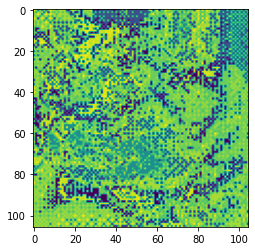

In [28]:


plt.imshow(img)

In [29]:
resnet

NameError: ignored